# Lending Tree Loan Status - Baseline Models

# Set Up Environment for Spark

## Paperspace Gradient


In [ ]:
# Install Java JRE/JDK in terminal
apt update
apt install default-jre
apt install default-jdk

In [ ]:
# Install findspark using pip
!pip install -q findspark
!pip install -U pyspark==3.3
import findspark
findspark.init()

In [ ]:
# Pyspark Session for Paperspace with more RAM & CPU cores available
# driver.memory=35g & executor.pyspark.memory=28 for some
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master('local')\
        .appName('Paperspace')\
        .config('spark.driver.memory', '38g')\
        .config('spark.executor.pyspark.memory', '32g')\
        .config('spark.executor.cores', '4')\
        .config('spark.python.worker.memory', '32g')\
        .config('spark.sql.execution.arrow.pyspark.enabled', 'True')\
        .config('spark.sql.debug.maxToStringFields', '1000')\
        .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/14 22:41:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# Remove warnings
spark.sparkContext.setLogLevel('ERROR')

# Install & Import Packages and Set Seed

In [ ]:
!pip install --upgrade mlflow 
!pip install hyperopt
import os
import random
import numpy as np
import warnings
from pyspark.sql.functions import col, round
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, LinearSVC
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
  import mlflow.pyspark.ml
  mlflow.pyspark.ml.autolog()
except:
  print(f'Your version of MLflow ({mlflow.__version__}) does not support pyspark.ml for autologging. To use autologging, upgrade your MLflow client version or use Databricks Runtime for ML 8.3 or above.')
warnings.filterwarnings('ignore')
my_dpi = 96 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.0 MB 14.8 MB/s 
     |████████████████████████████████| 146 kB 78.6 MB/s 
     |████████████████████████████████| 79 kB 8.2 MB/s 
     |████████████████████████████████| 181 kB 80.8 MB/s 
     |████████████████████████████████| 77 kB 6.9 MB/s 
     |████████████████████████████████| 209 kB 85.2 MB/s 
     |████████████████████████████████| 78 kB 6.2 MB/s 
     |████████████████████████████████| 55 kB 2.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 59 kB 7.6 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.17.3-py3-none-any.whl size=139102 sha256=bc092c8e6fe14820eb69e6e2d70cefe225dd7200a9bf8614f1ce331331ca4426
  Stored in directory: /root/.cache/pip/wheels/3f/73/87/c1e4b2145eb6049bb6c9aaf7ea1e38302b77ca219b6fef5d5c
Successfully built databricks-cli
Looking in indexes: htt

In [ ]:
# Set seed 
seed_value = 42
os.environ['SparkML_HPO'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# Upsampling - Oversample Minority Class 

## Read Data and View Schema

In [ ]:
trainDF = spark.read.csv('/cnotebooks/LoanStatus/Data/trainDF_US.csv',
                         header=True, inferSchema=True)
trainDF.cache()
print('\nTrain Schema')
trainDF.printSchema()

testDF = spark.read.csv('/notebooks/LoanStatus/Data/testDF_US.csv', 
                        header=True, inferSchema=True)
testDF.cache()
print('\nTest Schema')
testDF.printSchema()


Train Schema
root
 |-- loan_amnt: integer (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- out_prncp: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_rec_int: double (nullable = true)
 |-- total_rec_late_fee: double (nullable = true)
 |-- recoveries: double (nullable = true)
 |-- last_pymnt_amnt: double (nullable = true)
 |-- collections_12_mths_ex_med: double (nullable = true)
 |-- acc_open_past_24mths: double (nullable = true)
 |-- bc_open_to_buy: double (nullable = true)
 |-- chargeoff_within_12_mths: double (nullable = true)
 |-- delinq_amnt: double (nullable = true)
 |-- mths_since_recent_bc: double (nullable = true)
 |-- num_bc_sats: double (nullable = true)
 |-- num_bc_tl: double (nullable = true)
 |-- num_sats: double (nulla

## Set up Vector Assembler, Scalers and Evaluators

In [ ]:
# Define features and label for train data
features = trainDF.columns[0: len(trainDF.columns) - 1]
trainDF = trainDF.select(col('loan_status').alias('label'), *features)

In [ ]:
# VectorAssembler 
vecAssembler = VectorAssembler(inputCols=features, 
                               outputCol='unscaledFeatures', 
                               handleInvalid='skip')  

# Transform train data
trainDF = vecAssembler.transform(trainDF)  

In [ ]:
# Define features and label for test data 
features = testDF.columns[0: len(testDF.columns) - 1]
testDF = testDF.select(col('loan_status').alias('label'), *features)

# Transform test data
testDF = vecAssembler.transform(testDF)  

In [ ]:
# MinMaxScaler
mmScaler = MinMaxScaler(inputCol='unscaledFeatures', 
                        outputCol='scaledFeatures',
                        min=0, max=1)

In [ ]:
# Standard scaler
stdScaler = StandardScaler(inputCol='unscaledFeatures', 
                           outputCol='scaledFeatures', 
                           withStd=True, 
                           withMean=False)

In [ ]:
# Define model evaluation
evaluator_auroc = BinaryClassificationEvaluator(labelCol='label', 
                                                metricName='areaUnderROC')

evaluator_acc = MulticlassClassificationEvaluator(labelCol='label', 
                                                  metricName='accuracy')

## Logistic Regression

In [ ]:
# Set up logistic regression pipeline
lr = LogisticRegression(family='binomial', 
                        labelCol='label', 
                        featuresCol='scaledFeatures',  
                        regParam=0.0, 
                        elasticNetParam=0.0, 
                        maxIter=100)

search_time_start = time.time()
pipeline_lr = Pipeline(stages=[mmScaler, lr])
pipelineModel_lr_hyperopt = pipeline_lr.fit(trainDF)
pipelineModel_lr = pipeline_lr.fit(trainDF)
print('Time to fit baseline model:', time.time() - search_time_start)

Path = '/notebooks/LoanStatus/Python/ML/SparkML/Models/Baseline/baselineModel_lr_us'
pipelineModel_lr.save(Path)

2022/10/10 01:25:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4f23ebbab68a4183b8e16c8ad7a6cd2f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2022/10/10 01:27:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '50959865b44949f3bae0aebc0bfea305', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


Time to fit baseline model: 233.42002511024475


In [ ]:
# Predict on model
prediction_lr = pipelineModel_lr.transform(testDF)

lr_auroc = evaluator_auroc.evaluate(prediction_lr)
print('Baseline: LogisticRegression')
print('Area under ROC curve: %g' % (lr_auroc))
print('Test Error: %g' % (1.0 - lr_auroc))
print('Accuracy:', evaluator_acc.evaluate(prediction_lr)) 

Baseline: Logistic Regression
Area under ROC curve: 0.98701
Test Error: 0.0129899
Accuracy: 0.9858303292922332


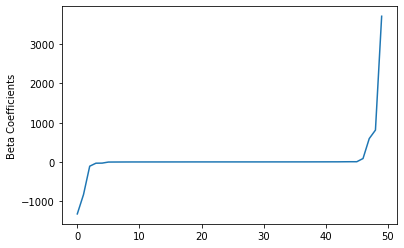

In [ ]:
# Set path to save results
save_results_to = '/notebooks/LoanStatus/Python/ML/SparkML/Models/Baseline/Results/'

# Extract info from pipeline
lr_info = pipelineModel_lr.stages[-1]
trainingSummary = lr_info.summary

# Beta coefficients
beta = np.sort(lr_info.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.savefig(save_results_to + 'Logistic_Baseline_US_betaCoef.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

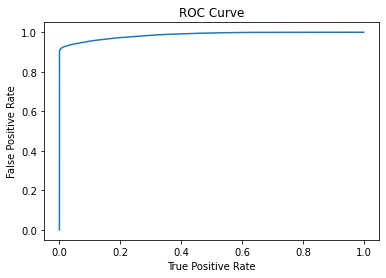


Training set areaUnderROC: 0.9862967238425067


In [ ]:
# ROC Curve
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(save_results_to + 'Logistic_Baseline_US_ROC.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()
print('\nTraining set areaUnderROC:' + str(trainingSummary.areaUnderROC))

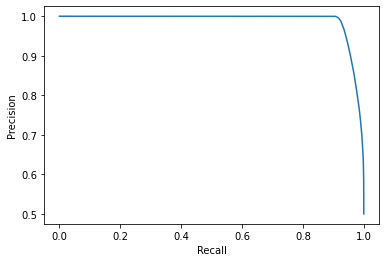

In [ ]:
# Precision Recall Curve
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig(save_results_to + 'Logistic_Baseline_US_RecallPrecision.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

## LinearSVC

In [ ]:
# Set up LinearSVC pipeline
lsvc = LinearSVC(labelCol='label', 
                 featuresCol='scaledFeatures', 
                 regParam=0.0, 
                 tol=1e-5, 
                 maxIter=100)

search_time_start = time.time()
pipeline_lsvc = Pipeline(stages=[stdScaler, lsvc])
pipelineModel_lsvc = pipeline_lsvc.fit(trainDF)
print('Time to fit baseline model:', time.time() - search_time_start)

Path = '/notebooks/LoanStatus/Python/ML/SparkML/Models/Baseline/baselineModel_lsvc_us'
pipelineModel_lsvc.save(Path)

2022/10/10 01:32:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6244b6c7087d40c9ba3bcecb84c96be2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


Time to fit baseline model: 154.46316194534302


In [ ]:
# Predict on model
prediction_lsvc = pipelineModel_lsvc.transform(testDF)

lsvc_auroc = evaluator_auroc.evaluate(prediction_lsvc)
print('Baseline: LinearSVC')
print('Area under ROC curve: %g' % (lsvc_auroc))
print('Test Error: %g' % (1.0 - lsvc_auroc))
print('Accuracy:', evaluator_acc.evaluate(prediction_lsvc)) 

Baseline: LinearSVC
Area under ROC curve: 0.978874
Test Error: 0.0211257


Accuracy: 0.9799987513671373


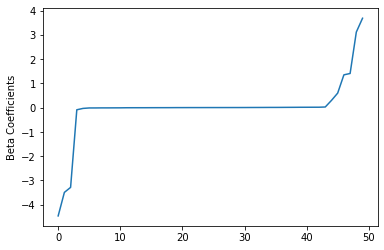

In [ ]:
# Extract info from pipeline
lsvc_info = pipelineModel_lsvc.stages[-1]
trainingSummary = lsvc_info.summary

# Beta coefficients
beta = np.sort(lsvc_info.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.savefig(save_results_to + 'LinearSVC_Baseline_US_betaCoef.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

## Decision Tree 

In [ ]:
# Set up DecisionTree pipeline
dt = DecisionTreeClassifier(labelCol='label', 
                            featuresCol='unscaledFeatures',
                            maxDepth=5,
                            maxBins=16, 
                            impurity='gini',
                            seed=seed_value)

search_time_start = time.time()
pipeline_dt = Pipeline(stages=[dt])
pipelineModel_dt = pipeline_dt.fit(trainDF)
print('Time to fit baseline model:', time.time() - search_time_start)

Path = '/notebooks/LoanStatus/Python/ML/SparkML/Models/Baseline/baselineModel_dt_us'
pipelineModel_dt.save(Path)

2022/10/10 01:35:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3d9d3090f60f46149b270867004547a7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


Time to fit baseline model: 59.340999603271484


In [ ]:
# Predict on model
prediction_dt = pipelineModel_dt.transform(testDF)

dt_auroc = evaluator_auroc.evaluate(prediction_dt)
print('Baseline: Decision Tree')
print('Area under ROC curve: %g' % (dt_auroc))
print('Test Error: %g' % (1.0 - dt_auroc))
print('Accuracy:', evaluator_acc.evaluate(prediction_dt)) 

Baseline: Decision Tree
Area under ROC curve: 0.913289
Test Error: 0.086711


Accuracy: 0.910900796119064


## Random Forest

In [ ]:
# Set up RandomForest pipeline
rf = RandomForestClassifier(labelCol='label', 
                            featuresCol='unscaledFeatures',
                            impurity='gini',
                            maxDepth=5,
                            maxBins=32, 
                            numTrees=10,
                            seed=seed_value)

search_time_start = time.time()
pipeline_rf = Pipeline(stages=[rf])
pipelineModel_rf = pipeline_rf.fit(trainDF)
print('Time to fit baseline model:', time.time() - search_time_start)

Path = '/notebooks/LoanStatus/Python/ML/SparkML/Models/Baseline/baselineModel_rf_us'
pipelineModel_rf.save(Path)

2022/10/10 01:36:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '56518e71367042c88e4508ccf0cdf517', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


Time to fit baseline model: 81.84045767784119


In [ ]:
# Predict on model
prediction_rf = pipelineModel_rf.transform(testDF)

rf_auroc = evaluator_auroc.evaluate(prediction_rf)
print('Baseline: Random Forest')
print('Area under ROC curve: %g' % (rf_auroc))
print('Test Error: %g' % (1.0 - rf_auroc))
print('Accuracy:', evaluator_acc.evaluate(prediction_rf)) 

Baseline: Random Forest
Area under ROC curve: 0.960471
Test Error: 0.0395285


Accuracy: 0.9159831943265823


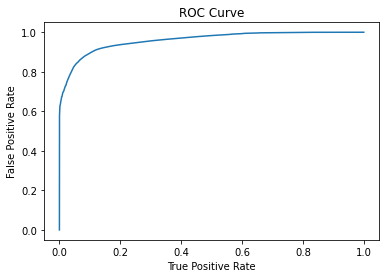


Training set areaUnderROC: 0.9597451925875579


In [ ]:
# Extract info from pipeline
rf_info = pipelineModel_rf.stages[-1]
trainingSummary = rf_info.summary

# ROC Curve
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(save_results_to + 'RF_Baseline_US_ROC.png', dpi=my_dpi*10, 
            bbox_inches='tight')

plt.show()
print('\nTraining set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

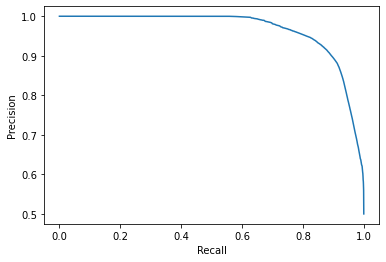

In [ ]:
# Precision Recall Curve
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig(save_results_to + 'RF_Baseline_US_RecallPrecision.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

## Gradient Boosted Trees

In [ ]:
# Set up GBT pipeline
gbt = GBTClassifier(labelCol='label', 
                    featuresCol='unscaledFeatures', 
                    maxDepth=5, 
                    maxBins=32, 
                    maxIter=10,
                    seed=seed_value)

search_time_start = time.time()
pipeline_gbt = Pipeline(stages=[gbt])
pipelineModel_gbt = pipeline_gbt.fit(trainDF)
print('Time to fit baseline model:', time.time() - search_time_start)

Path = '/notebooks/LoanStatus/Python/ML/SparkML/Models/Baseline/baselineModel_gbt_us'
pipelineModel_gbt.save(Path)

2022/10/10 01:38:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '51428177e006441b8bc7be07be8f4d09', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


Time to fit baseline model: 124.68918800354004


In [ ]:
# Predict on model
prediction_gbt = pipelineModel_gbt.transform(testDF)

gbt_auroc = evaluator_auroc.evaluate(prediction_gbt)
print('Baseline: Gradient Boosted Trees')
print('Area under ROC curve: %g' % (gbt_auroc))
print('Test Error: %g' % (1.0 - gbt_auroc))
print('Accuracy:', evaluator_acc.evaluate(prediction_gbt)) 

Baseline: Gradient Boosted Trees
Area under ROC curve: 0.972706
Test Error: 0.0272944


Accuracy: 0.9430554046148546


## Model Metrics

In [ ]:
print('Upsampling Baseline Models:')
for model in ['prediction_lr', 'prediction_lsvc', 'prediction_dt',
              'prediction_rf', 'prediction_gbt']:
    df = globals()[model]
    
    tp = df[(df.label == 1) & (df.prediction == 1)].count()
    tn = df[(df.label == 0) & (df.prediction == 0)].count()
    fp = df[(df.label == 0) & (df.prediction == 1)].count()
    fn = df[(df.label == 1) & (df.prediction == 0)].count()
    a = ((tp + tn)/df.count())
    
    if(tp + fn == 0.0):
        r = 0.0
        p = float(tp) / (tp + fp)
    elif(tp + fp == 0.0):
        r = float(tp) / (tp + fn)
        p = 0.0
    else:
        r = float(tp) / (tp + fn)
        p = float(tp) / (tp + fp)
    
    if(p + r == 0):
        f1 = 0
    else:
        f1 = 2 * ((p * r)/(p + r))
    
    print('\nModel:', model)
    print('True Positives:', tp)
    print('True Negatives:', tn)
    print('False Positives:', fp)
    print('False Negatives:', fn)
    print('Total:', df.count())
    print('Accuracy:', a)
    print('Recall:', r)
    print('Precision: ', p)
    print('F1 score:', f1)
    print('\n')

Upsampling Baseline Models:



Model: prediction_lr
True Positives: 50199
True Negatives: 376146
False Positives: 1702
False Negatives: 4426
Total: 432473
Accuracy: 0.9858303292922332
Recall: 0.918974828375286
Precision:  0.9672067975568871
F1 score: 0.9424741377691831





Model: prediction_lsvc
True Positives: 48472
True Negatives: 375351
False Positives: 2497
False Negatives: 6153
Total: 432473
Accuracy: 0.9799987513671373
Recall: 0.8873592677345538
Precision:  0.9510094371088309
F1 score: 0.9180824668068263





Model: prediction_dt
True Positives: 49091
True Negatives: 344849
False Positives: 32999
False Negatives: 5534
Total: 432473
Accuracy: 0.910900796119064
Recall: 0.8986910755148741
Precision:  0.5980143744670484
F1 score: 0.7181508978531983





Model: prediction_rf
True Positives: 47783
True Negatives: 348355
False Positives: 29493
False Negatives: 6842
Total: 432473
Accuracy: 0.9159831943265823
Recall: 0.874745995423341
Precision:  0.6183420466897872
F1 score: 0.7245282446683496





Model: prediction_gbt
True Positives: 49134
True Negatives: 358712
False Positives: 19136
False Negatives: 5491
Total: 432473
Accuracy: 0.9430554046148546
Recall: 0.8994782608695652
Precision:  0.7197011864655046
F1 score: 0.7996094226778957




# SMOTE - Split Over Upsampling 

## Read Data and View Schema

In [ ]:
trainDF = spark.read.csv('/content/drive/MyDrive/LoanStatus/Data/trainDF_SMOTE.csv',
                         header=True, inferSchema=True)
trainDF.cache()
trainDF = trainDF \
  .withColumn('loan_amnt', trainDF['loan_amnt'].cast(IntegerType())) \
  .withColumn('revol_bal', trainDF['revol_bal'].cast(IntegerType())) \
  .withColumn('term_ 60 months', trainDF['term_ 60 months'].cast(IntegerType())) \
  .withColumn('grade_B', trainDF['grade_B'].cast(IntegerType())) \
  .withColumn('grade_C', trainDF['grade_C'].cast(IntegerType())) \
  .withColumn('grade_D', trainDF['grade_D'].cast(IntegerType())) \
  .withColumn('home_ownership_MORTGAGE', trainDF['home_ownership_MORTGAGE'].cast(IntegerType())) \
  .withColumn('home_ownership_OWN', trainDF['home_ownership_OWN'].cast(IntegerType())) \
  .withColumn('home_ownership_RENT', trainDF['home_ownership_RENT'].cast(IntegerType())) \
  .withColumn('verification_status_Source Verified', trainDF['verification_status_Source Verified'].cast(IntegerType())) \
  .withColumn('verification_status_Verified', trainDF['verification_status_Verified'].cast(IntegerType())) \
  .withColumn('purpose_credit_card', trainDF['purpose_credit_card'].cast(IntegerType())) \
  .withColumn('initial_list_status_w', trainDF['initial_list_status_w'].cast(IntegerType())) \
  .withColumn('application_type_Joint App', trainDF['application_type_Joint App'].cast(IntegerType())) \
  .withColumn('disbursement_method_DirectPay', trainDF['disbursement_method_DirectPay'].cast(IntegerType())) 
print('\nTrain Schema')
trainDF.printSchema()

testDF = spark.read.csv('/content/drive/MyDrive/LoanStatus/Data/testDF_SMOTE.csv',
                        header=True, inferSchema=True)
testDF.cache()
print('\nTest Schema')
testDF.printSchema()


Train Schema
root
 |-- loan_amnt: integer (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- out_prncp: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_rec_int: double (nullable = true)
 |-- total_rec_late_fee: double (nullable = true)
 |-- recoveries: double (nullable = true)
 |-- last_pymnt_amnt: double (nullable = true)
 |-- collections_12_mths_ex_med: double (nullable = true)
 |-- acc_open_past_24mths: double (nullable = true)
 |-- bc_open_to_buy: double (nullable = true)
 |-- chargeoff_within_12_mths: double (nullable = true)
 |-- delinq_amnt: double (nullable = true)
 |-- mths_since_recent_bc: double (nullable = true)
 |-- num_bc_sats: double (nullable = true)
 |-- num_bc_tl: double (nullable = true)
 |-- num_sats: double (nulla

## Set up Vector Assembler

In [ ]:
# Define features and label for train data
features = trainDF.columns[0: len(trainDF.columns) - 1]
trainDF = trainDF.select(col('loan_status').alias('label'), *features)

# Transform train data
trainDF = vecAssembler.transform(trainDF)  

In [ ]:
# Define features and label for test data 
features = testDF.columns[0: len(testDF.columns) - 1]
testDF = testDF.select(col('loan_status').alias('label'), *features)

# Transform test data
testDF = vecAssembler.transform(testDF)  

## Logistic Regression

In [ ]:
# Set up logistic regression pipeline
lr = LogisticRegression(family='binomial', 
                        labelCol='label', 
                        featuresCol='scaledFeatures',  
                        regParam=0.0, 
                        elasticNetParam=0.0, 
                        maxIter=100)

search_time_start = time.time()
pipeline_lr = Pipeline(stages=[mmScaler, lr])
pipelineModel_lr = pipeline_lr.fit(trainDF)
print('Time to fit baseline model:', time.time() - search_time_start)

Path = '/notebooks/LoanStatus/Python/ML/SparkML/Models/Baseline/baselineModel_lr_smote'
pipelineModel_lr.save(Path)

2022/10/10 01:41:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ee55f19131ad4adcae453703c5f3daec', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


Time to fit baseline model: 121.01508712768555


In [ ]:
# Predict on model
prediction_lr = pipelineModel_lr.transform(testDF)

lr_auroc = evaluator_auroc.evaluate(prediction_lr)
print('Baseline: Logistic Regression')
print('Area under ROC curve: %g' % (lr_auroc))
print('Test Error: %g' % (1.0 - lr_auroc))
print('Accuracy:', evaluator_acc.evaluate(prediction_lr)) 

Baseline: Logistic Regression
Area under ROC curve: 0.979804
Test Error: 0.0201956
Accuracy: 0.9857540239506282


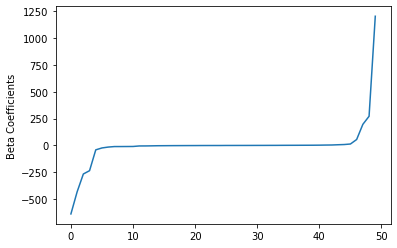

In [ ]:
# Extract info from pipeline
lr_info = pipelineModel_lr.stages[-1]
trainingSummary = lr_info.summary

# Beta coefficients
beta = np.sort(lr_info.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.savefig(save_results_to + 'Logistic_Baseline_SMOTE_betaCoef.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

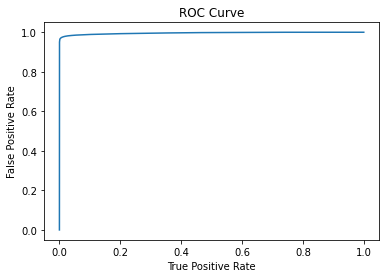


Training set areaUnderROC: 0.9960903540663115


In [ ]:
# ROC Curve
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(save_results_to + 'Logistic_Baseline_SMOTE_ROC.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()
print('\nTraining set areaUnderROC:' + str(trainingSummary.areaUnderROC))

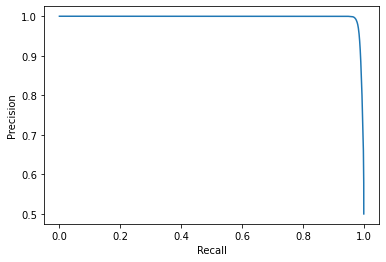

In [ ]:
# Precision Recall Curve
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig(save_results_to + 'Logistic_Baseline_SMOTE_RecallPrecision.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

## LinearSVC

In [ ]:
# Set up LinearSVC pipeline
lsvc = LinearSVC(labelCol='label', 
                 featuresCol='scaledFeatures', 
                 regParam=0.0, 
                 tol=1e-5, 
                 maxIter=100)

search_time_start = time.time()
pipeline_lsvc = Pipeline(stages=[stdScaler, lsvc])
pipelineModel_lsvc = pipeline_lsvc.fit(trainDF)
print('Time to fit baseline model:', time.time() - search_time_start)

Path = '/notebooks/LoanStatus/Python/ML/SparkML/Models/Baseline/baselineModel_lsvc_smote'
pipelineModel_lsvc.save(Path)

2022/10/10 01:45:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0cbc28d50afe499087fe00a0d33b4d94', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


Time to fit baseline model: 134.26036667823792


In [ ]:
# Predict on model
prediction_lsvc = pipelineModel_lsvc.transform(testDF)

lsvc_auroc = evaluator_auroc.evaluate(prediction_lsvc)
print('Baseline: LinearSVC')
print('Area under ROC curve: %g' % (lsvc_auroc))
print('Test Error: %g' % (1.0 - lsvc_auroc))
print('Accuracy:', evaluator_acc.evaluate(prediction_lsvc)) 

Baseline: LinearSVC
Area under ROC curve: 0.977104
Test Error: 0.0228963


Accuracy: 0.9829214771789222


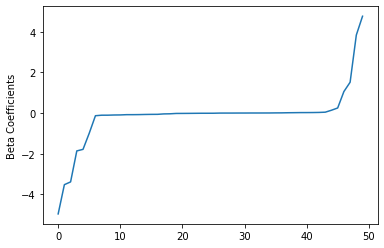

In [ ]:
# Extract info from pipeline
lsvc_info = pipelineModel_lsvc.stages[-1]
trainingSummary = lsvc_info.summary

# Beta coefficients
beta = np.sort(lsvc_info.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.savefig(save_results_to + 'LinearSVC_Baseline_SMOTE_betaCoef.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

## Decision Tree 

In [ ]:
# Set up DecisionTree pipeline
dt = DecisionTreeClassifier(labelCol='label', 
                            featuresCol='unscaledFeatures',
                            maxDepth=5,
                            maxBins=16, 
                            impurity='gini',
                            seed=seed_value)

search_time_start = time.time()
pipeline_dt = Pipeline(stages=[dt])
pipelineModel_dt = pipeline_dt.fit(trainDF)
print('Time to fit baseline model:', time.time() - search_time_start)

Path = '/notebooks/LoanStatus/Python/ML/SparkML/Models/Baseline/baselineModel_dt_smote'
pipelineModel_dt.save(Path)

2022/10/10 01:47:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1a66c94a0f2e4043af3203374cf7b774', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


Time to fit baseline model: 61.8033344745636


In [ ]:
# Predict on model
prediction_dt = pipelineModel_dt.transform(testDF)

dt_auroc = evaluator_auroc.evaluate(prediction_dt)
print('Baseline: Decision Tree')
print('Area under ROC curve: %g' % (dt_auroc))
print('Test Error: %g' % (1.0 - dt_auroc))
print('Accuracy:', evaluator_acc.evaluate(prediction_dt)) 

Baseline: Decision Tree
Area under ROC curve: 0.92133
Test Error: 0.0786704


Accuracy: 0.9362596046458391


## Random Forest

In [ ]:
# Set up RandomForest pipeline
rf = RandomForestClassifier(labelCol='label', 
                            featuresCol='unscaledFeatures', 
                            maxDepth=5,
                            maxBins=32,
                            numTrees=10,
                            impurity='gini',
                            seed=seed_value)

search_time_start = time.time()
pipeline_rf = Pipeline(stages=[rf])
pipelineModel_rf = pipeline_rf.fit(trainDF)
print('Time to fit baseline model:', time.time() - search_time_start)

Path = '/notebooks/LoanStatus/Python/ML/SparkML/Models/Baseline/baselineModel_rf_smote'
pipelineModel_rf.save(Path)

2022/10/10 01:48:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '78f94c87b037438195ad4e4064490fca', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


Time to fit baseline model: 82.65176653862


In [ ]:
# Predict on model
prediction_rf = pipelineModel_rf.transform(testDF)

rf_auroc = evaluator_auroc.evaluate(prediction_rf)
print('Baseline: Random Forest')
print('Area under ROC curve: %g' % (rf_auroc))
print('Test Error: %g' % (1.0 - rf_auroc))
print('Accuracy:', evaluator_acc.evaluate(prediction_rf)) 

Baseline: Random Forest
Area under ROC curve: 0.941545
Test Error: 0.0584552


Accuracy: 0.9482372309947673


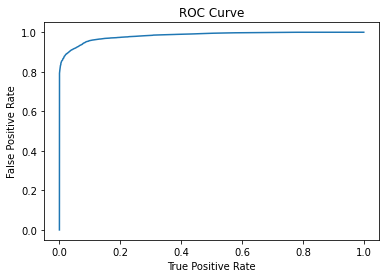


Training set areaUnderROC: 0.9833452389570888


In [ ]:
# Extract info from pipeline
rf_info = pipelineModel_rf.stages[-1]
trainingSummary = rf_info.summary

# ROC Curve
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(save_results_to + 'RF_Baseline_SMOTE_ROC.png', dpi=my_dpi*10, 
            bbox_inches='tight')

plt.show()
print('\nTraining set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

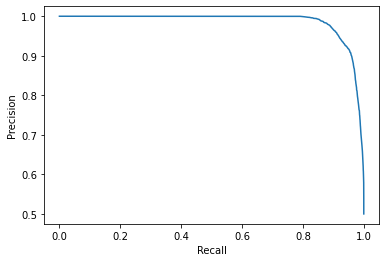

In [ ]:
# Precision Recall Curve
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig(save_results_to + 'RF_Baseline_SMOTE_RecallPrecision.png', 
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

## Gradient Boosted Trees

In [ ]:
# Set up GBT pipeline
gbt = GBTClassifier(labelCol='label', 
                    featuresCol='unscaledFeatures', 
                    maxDepth=5, 
                    maxBins=32, 
                    maxIter=10,
                    seed=seed_value)

search_time_start = time.time()
pipeline_gbt = Pipeline(stages=[gbt])
pipelineModel_gbt = pipeline_gbt.fit(trainDF)
print('Time to fit baseline model:', time.time() - search_time_start)

Path = '/notebooks/LoanStatus/Python/ML/SparkML/Models/Baseline/baselineModel_gbt_smote'
pipelineModel_gbt.save(Path)

2022/10/10 01:51:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3cd40588f9e145b394b199b2611df978', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


Time to fit baseline model: 126.09147500991821


In [ ]:
# Predict on model
prediction_gbt = pipelineModel_gbt.transform(testDF)

gbt_auroc = evaluator_auroc.evaluate(prediction_gbt)
print('Baseline: Gradient Boosted Trees')
print('Area under ROC curve: %g' % (gbt_auroc))
print('Test Error: %g' % (1.0 - gbt_auroc))
print('Accuracy:', evaluator_acc.evaluate(prediction_gbt)) 

Baseline: Gradient Boosted Trees
Area under ROC curve: 0.970601
Test Error: 0.0293991


Accuracy: 0.9605848226363264


## Model Metrics

In [ ]:
print('SMOTE Baseline Models:')
for model in ['prediction_lr', 'prediction_lsvc', 'prediction_dt', 
              'prediction_rf', 'prediction_gbt']:
    df = globals()[model]
    
    tp = df[(df.label == 1) & (df.prediction == 1)].count()
    tn = df[(df.label == 0) & (df.prediction == 0)].count()
    fp = df[(df.label == 0) & (df.prediction == 1)].count()
    fn = df[(df.label == 1) & (df.prediction == 0)].count()
    a = ((tp + tn)/df.count())
    
    if(tp + fn == 0.0):
        r = 0.0
        p = float(tp) / (tp + fp)
    elif(tp + fp == 0.0):
        r = float(tp) / (tp + fn)
        p = 0.0
    else:
        r = float(tp) / (tp + fn)
        p = float(tp) / (tp + fp)
    
    if(p + r == 0):
        f1 = 0
    else:
        f1 = 2 * ((p * r)/(p + r))
    
    print('\nModel:', model)
    print('True Positives:', tp)
    print('True Negatives:', tn)
    print('False Positives:', fp)
    print('False Negatives:', fn)
    print('Total:', df.count())
    print('Accuracy:', a)
    print('Recall:', r)
    print('Precision: ', p)
    print('F1 score:', f1)
    print('\n')

SMOTE Baseline Models:



Model: prediction_lr
True Positives: 49671
True Negatives: 376641
False Positives: 1207
False Negatives: 4954
Total: 432473
Accuracy: 0.9857540239506282
Recall: 0.9093089244851259
Precision:  0.9762765831990251
F1 score: 0.9416035562969773





Model: prediction_lsvc
True Positives: 48070
True Negatives: 377017
False Positives: 831
False Negatives: 6555
Total: 432473
Accuracy: 0.9829214771789222
Recall: 0.88
Precision:  0.9830064824850208
F1 score: 0.9286556034232947





Model: prediction_dt
True Positives: 43557
True Negatives: 361350
False Positives: 16498
False Negatives: 11068
Total: 432473
Accuracy: 0.9362596046458391
Recall: 0.7973821510297483
Precision:  0.7252851552743319
F1 score: 0.7596267875828393





Model: prediction_rf
True Positives: 34722
True Negatives: 375365
False Positives: 2483
False Negatives: 19903
Total: 432473
Accuracy: 0.9482372309947673
Recall: 0.6356430205949657
Precision:  0.9332616583792501
F1 score: 0.7562234563868017





Model: prediction_gbt
True Positives: 43402
True Negatives: 372025
False Positives: 5823
False Negatives: 11223
Total: 432473
Accuracy: 0.9605848226363264
Recall: 0.7945446224256293
Precision:  0.8817064499746065
F1 score: 0.8358594126143477


